<a href="https://colab.research.google.com/github/darisoy/EE596_Final_Project/blob/main/Room_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Suppress Warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import torch
from zipfile import ZipFile
import numpy as np
from torch import nn
import torchvision
from torchvision import datasets
import torch.nn.functional as F
import torchvision.transforms as T
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
from PIL import Image
from tqdm import tqdm_notebook as tqdm
import os
import glob
import random

In [3]:
gpu = torch.cuda.is_available()
if gpu:
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

print('Using device', device)

Using device cuda


In [4]:
with ZipFile('/content/drive/MyDrive/furnished_cropped.zip', 'r') as trainZip:
  trainZip.extractall('/content/train/furnished')

with ZipFile('/content/drive/MyDrive/empty_cropped.zip', 'r') as testZip:
  testZip.extractall('/content/train/empty')

In [4]:
trf = T.Compose([T.Resize(227),
                 T.CenterCrop(227),
                 T.ToTensor(),
                 T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                 ])
data = datasets.ImageFolder('/content/train', transform=trf)
train_size = int(0.8 * len(data))
valid_size = len(data) - train_size
train_data, valid_data = torch.utils.data.random_split(data, [train_size, valid_size])

In [5]:
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=64)
valid_loader = torch.utils.data.DataLoader(valid_data, shuffle=True, batch_size=64)

In [6]:
class AlexNet(nn.Module):
  """
  Neural network model consisting of layers propsed by AlexNet paper.
  """
  def __init__(self, num_classes=2):
    """
    Define and allocate layers for this neural net.
    Args:
        num_classes (int): number of classes to predict with this model
    """
    super(AlexNet, self).__init__()
    self.net = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4).cuda(),
        nn.ReLU().cuda(),
        nn.MaxPool2d(kernel_size=3, stride=2).cuda(),
        nn.ReLU().cuda(),
        nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2).cuda(),
        nn.ReLU().cuda(),
        nn.MaxPool2d(kernel_size=3, stride=2).cuda(),
        nn.ReLU().cuda(),
        nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1).cuda(),
        nn.ReLU().cuda(),
        nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1).cuda(),
        nn.ReLU().cuda(),
        nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1).cuda(),
        nn.ReLU().cuda(),
        nn.MaxPool2d(kernel_size=3, stride=2).cuda(),
        nn.ReLU().cuda(),
    )
    self.classifier = nn.Sequential(
        nn.Dropout(),
        nn.Linear(6*6*256, 4096).cuda(),
        nn.ReLU().cuda(),
        nn.Dropout(),
        nn.Linear(4096, 4096).cuda(),
        nn.ReLU().cuda(),
        nn.Linear(4096, num_classes).cuda(),
    )

    self.activation = nn.Softmax(dim=1).cuda()
    
    self.init_bias()

  def init_bias(self):
    # Initialize weights according to original paper
    for layer in self.net:
      if isinstance(layer, nn.Conv2d):
        nn.init.normal_(layer.weight, mean=0, std=0.01)
        nn.init.constant_(layer.bias, 0)
    nn.init.constant_(self.net[4].bias, 1)
    nn.init.constant_(self.net[10].bias, 1)
    nn.init.constant_(self.net[12].bias, 1)

  def forward(self, x):
    x = self.net(x)
    x = x.view(-1, 6*6*256)
    x = self.classifier(x)
    prob = self.activation(x)
    return x, prob

In [7]:
#Define hyperparameters
seed = torch.initial_seed()
model = AlexNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
epochs = 10
criterion = nn.CrossEntropyLoss()

In [8]:
# Train the model
for epoch in range(epochs):
  running_loss = 0.0
  for inputs, labels in tqdm(train_loader):
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs, _ = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  print('[Epoch %d]\tTrain Loss: \t\t%.3f' % (epoch+1, running_loss / len(train_loader)))


[Epoch 1]	Train Loss: 		0.782



[Epoch 2]	Train Loss: 		0.693



[Epoch 3]	Train Loss: 		0.693



[Epoch 4]	Train Loss: 		0.692



[Epoch 5]	Train Loss: 		0.626



[Epoch 6]	Train Loss: 		0.490



[Epoch 7]	Train Loss: 		0.352



[Epoch 8]	Train Loss: 		0.285



[Epoch 9]	Train Loss: 		0.257



[Epoch 10]	Train Loss: 		0.266


In [9]:
#Calculate loss on test set
correct = 0
total = 0
total_loss = 0
with torch.no_grad():
  for inputs, labels in tqdm(valid_loader):
    inputs, labels = inputs.to(device), labels.to(device)
    outputs, _ = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    total_loss += criterion(outputs, labels).item()

print('Validation Loss: \t%.3f' % (total_loss / len(valid_loader)))
print('Validation Accuracy: \t%.2f %%' % (100 * correct / total))


Validation Loss: 	0.256
Validation Accuracy: 	89.84 %


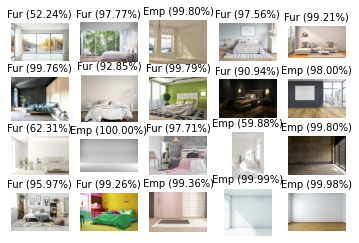

In [10]:
images = glob.glob("/content/train/empty/*jpg")
images.extend(glob.glob("/content/train/furnished/*jpg"))

count = 0
for i in random.sample(range(0, len(images)), 20):
  image = Image.open(images[i])
  input = trf(image)
  input = torch.unsqueeze(input, 0)
  input = input.to(device)
  output, probs = model(input)
  _, predicted = torch.max(output.data, 1)

  count += 1
  plt.subplot(4, 5, count)
  plt.imshow(image)
  title = 'Emp'
  if predicted[0]:
    title = 'Fur'

  title += (' (%.2f%%)' % (torch.max(probs)*100))
  plt.title(title, fontsize=10)
  plt.axis('off')

plt.show()